# Goal
* project rotated ellipsoid

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor

import sympy
from sympy import symbols, simplify, solve, var

from scipy.spatial.transform import Rotation

from compSPI import transforms
from simSPI.geometric_micelle import projected_rotated_circle


# $x^TQx$
* check equations from https://math.stackexchange.com/questions/573055/projection-of-ellipsoid
  * $C = (PQ^{-1}P^T)^{-1}$
* Q is the equation of the (roated) elipse in 3D
* consider the elipse: $x^2 + y^2 + xy + z^2 = 1$
  * we get this parametric form from $x^TQx$
  * when we rotate a point, we get $(Rx)^TQ(Rx) = x^T (R^TQR)x$
* P is for the xy plane

In [3]:
Q = np.array([[1,-0.5,0,0],[-0.5,1,0,0],[0,0,1,0],[0,0,0,-1]])
Qinv = np.linalg.inv(Q)

In [5]:
Qinv

array([[ 1.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.66666667,  1.33333333,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [-0.        , -0.        , -0.        , -1.        ]])

In [1407]:
P = np.zeros((3,4))
P[0,0] = P[1,1] = P[2,3] = 1
P

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [9]:
C = np.linalg.inv(P @ Qinv @P.T)

In [10]:
C

array([[ 1. , -0.5,  0. ],
       [-0.5,  1. ,  0. ],
       [-0. , -0. , -1. ]])

# Rotate elipse
* $1x^2 + 2y^2 + 3z^2 = 1$


## rotate 90 deg in xy plane
* rotate by 90 deg about the z axis
* rotated elipse
* note that $R^TQR$ plays the role of $Q$ in the unrotated case

In [1403]:
R = np.zeros((4,4))
theta = np.deg2rad(90)
c = np.cos(theta)
s = np.sin(theta)
R[:2,:2] = np.array([[c,-s],[s,c]])
R[-1,-1] = R[-2,-2] = 1
R

array([[ 6.123234e-17, -1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 1.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [1404]:
Q = np.diag([1,2,3,-1])
Q

array([[ 1,  0,  0,  0],
       [ 0,  2,  0,  0],
       [ 0,  0,  3,  0],
       [ 0,  0,  0, -1]])

In [1405]:
Q_rot = R.T @ Q @ R
Q_rot

array([[ 2.000000e+00,  6.123234e-17,  0.000000e+00,  0.000000e+00],
       [ 6.123234e-17,  1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  3.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, -1.000000e+00]])

In [1408]:
Qinv = np.linalg.inv(Q_rot)
C = np.linalg.inv(P @ Qinv @P.T)

In [1409]:
C

array([[ 2.000000e+00,  6.123234e-17,  0.000000e+00],
       [ 6.123234e-17,  1.000000e+00,  0.000000e+00],
       [-0.000000e+00, -0.000000e+00, -1.000000e+00]])

# Rotate circle 

## from xy plane to 3D
* https://math.stackexchange.com/a/2962856

In [1448]:
R = np.zeros((4,4))
theta = np.deg2rad(90)
c = np.cos(theta)
s = np.sin(theta)
R[:3,:3] = Rotation.from_euler('zyx',[20,20,20],degrees=True).as_matrix()
R[-1,-1] = 1

In [1449]:
Q = np.diag([1,1,1,-1])


In [1450]:
Q_rot = R.T @ Q @ R
Qinv = np.linalg.inv(Q_rot)
C = np.linalg.inv(P @ Qinv @P.T)
C

array([[ 1.00000000e+00, -5.55111512e-17,  0.00000000e+00],
       [-5.55111512e-17,  1.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -1.00000000e+00]])

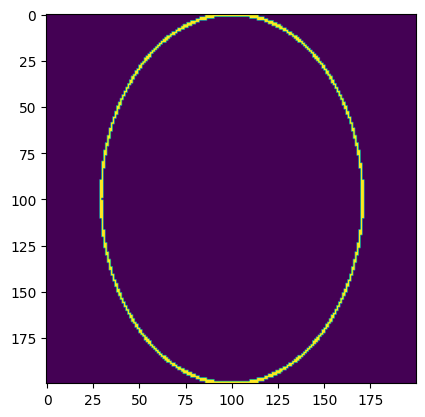

In [1491]:
rotation = Rotation.from_euler('XYZ',[0,45,0],degrees=True).as_matrix()

axis = rotation[:,-1]
nx, ny, nz = axis
d=0

# C = np.array(
#     [nx*nx+ny*ny, nx*ny, nx*d],
#     [nx*nz, nz*nz+ny*ny, nz*d],
#     [nx*d, ny*d, d*d-ny*ny])

a, b = 1, 1
step_x, step_y = 0.01, 0.01
x_mesh, y_mesh = np.meshgrid(np.arange(-a,a,step=step_x),np.arange(-b,b,step=step_y))

x, y = x_mesh, y_mesh
el = np.isclose((nx*nx+nz*nz)*x*x + 2*nx*ny*x*y + (nz*nz+ny*ny)*y*y - nz*nz,0,atol=0.01)
plt.imshow(el)

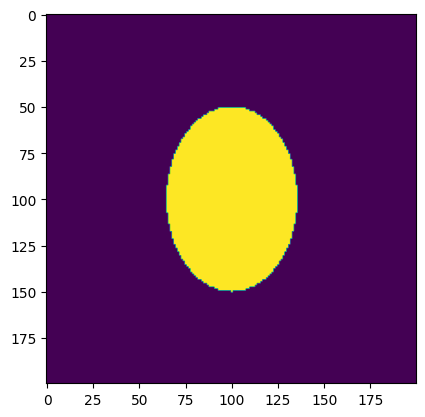

In [1494]:
a, b = 10, 10
step_x, step_y = 0.1, 0.1
x_mesh, y_mesh = np.meshgrid(np.arange(-a,a,step=step_x),np.arange(-b,b,step=step_y))
x, y = x_mesh, y_mesh
rad=5
el = (nx*nx+nz*nz)*x*x + 2*nx*ny*x*y + (nz*nz+ny*ny)*y*y - nz*nz*rad*rad < 0
plt.imshow(el)

In [1495]:
# def projected_rotated_circle(x, y, radius_circle, rotation):
#     '''
#     https://math.stackexchange.com/a/2962856
#     '''
#     normal_axis = rotation[:,-1] # rotation dotted with zaxis (want to project)
#     nx, ny, nz = axis
#     ellipse = (nx*nx+nz*nz)*x*x + 2*nx*ny*x*y + (nz*nz+ny*ny)*y*y - nz*nz*radius_circle*radius_circle < 0
#     return ellipse

def projected_rotated_circle(x, y, radius_circle, rotation):
    '''
    https://math.stackexchange.com/a/2962856
    '''
    normal_axis = rotation[:, -1]  # rotation dotted with zaxis (projection axis)
    nx, ny, nz = normal_axis
    ellipse = (nx * nx + nz * nz) * x * x + 2 * nx * ny * x * y + (nz * nz + ny * ny) * y * y - nz * nz * radius_circle * radius_circle < 0
    return ellipse

In [1541]:
# tests
projected_rotated_circle(x, y, radius_circle, rotation)
a, b = 1, 1
step_x, step_y = 0.01, 0.01
x_mesh, y_mesh = np.meshgrid(np.arange(-a,a,step=step_x),np.arange(-b,b,step=step_y))
x, y = x_mesh, y_mesh

# test case of 45 deg which should shrink area to known ratio
rotation = Rotation.from_euler('ZYX',[0,0,45],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
area_circle = circle_identity.sum()
axis_contraction = np.sqrt(2)
assert np.isclose(circle_identity.sum() / ellipse.sum(), axis_contraction, atol=1e-3) # pi r^2 / (pi a b), with a = r/sqrt(2), b=r

rotation = Rotation.from_euler('ZYX',[0,45,0],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
area_circle = circle_identity.sum()
axis_contraction = np.sqrt(2)
assert np.isclose(circle_identity.sum() / ellipse.sum(), axis_contraction, atol=1e-3) # pi r^2 / (pi a b), with a = r/sqrt(2), b=r

## test direction
rotation = Rotation.from_euler('ZYX',[0,0,45],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
assert ellipse.sum(0).max() < ellipse.sum(1).max()

## test case of 45 deg which should shrink area to ratio
rotation = Rotation.from_euler('ZYX',[0,45,0],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
assert ellipse.sum(0).max() > ellipse.sum(1).max()

## test 90 deg
rotation = Rotation.from_euler('ZYX',[0,90,0],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
assert np.isclose(ellipse.sum(),0)

rotation = Rotation.from_euler('ZYX',[0,0,90],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
assert np.isclose(ellipse.sum(),0)

rotation = Rotation.from_euler('ZYX',[0,90,90],degrees=True).as_matrix()
ellipse = projected_rotated_circle(x, y, radius_circle=1, rotation=rotation)
assert np.isclose(ellipse.sum(),0)

# rotate in z plane
random_angle = np.random.uniform(low=0,high=360)
rotation = Rotation.from_euler('ZYX',[random_angle,0,0],degrees=True).as_matrix()
circle_random = projected_rotated_circle(x, y, radius_circle, rotation=rotation)
circle_identity = projected_rotated_circle(x, y, radius_circle, rotation=np.eye(3))
assert np.allclose(circle_random,circle_identity)

## test identity
radius_circle=1
circle = projected_rotated_circle(x, y, radius_circle, rotation=np.eye(3))
normalized_area_circle = circle.mean()
area_square = 2*2
assert np.isclose(normalized_area_circle, np.pi*radius_circle**2/area_square,atol=1e-3) # pi r^2 / 4 with r=1, box is area 4



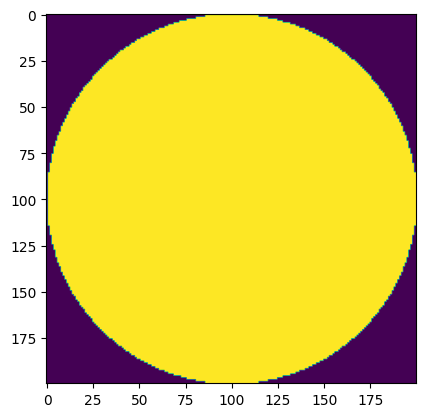

In [1543]:
plt.imshow(circle)

# Rotate about (1,1,1) vector by 45 deg

In [43]:
import pytorch3d.transforms
import torch
from torch import tensor

In [53]:
R = np.zeros((4,4))
R[:3,:3] = pytorch3d.transforms.axis_angle_to_matrix(torch.deg2rad(tensor(45.))*tensor([1,1,1])).numpy()
R[-1,-1] = 1

In [54]:
Q = np.diag([1,2,3,-1])
Q_rot = R.T @ Q @ R
Qinv = np.linalg.inv(Q_rot)
C = np.linalg.inv(P @ Qinv @P.T)
C

array([[ 1.68193036,  0.11538913,  0.        ],
       [ 0.11538913,  2.32851466,  0.        ],
       [-0.        , -0.        , -1.        ]])

# Rotate elipse in xy plane above z axis
* 1x^2 + 2y^2 + 1 = 1
* https://math.stackexchange.com/questions/73237/parametric-equation-of-a-circle-in-3d-space

# Fourier slice theorem
1. Numerically evaluate (rotated) ellipsoid on grid
2. Line integral

OR
1. Precomptue 3D FFT elipse
2. extract rotated slice (interpolate)
3. do 2D iFFT

In [17]:
import numpy as np

a = 1.0
b = 2.0
c = 3.0
nx = 256   # number of pixels in x-dir
ny = 256   # number of pixels in y-dir
nz = 256

# set up a coordinate system
x = np.linspace(-5.0, 5.0, nx)
y = np.linspace(-5.0, 5.0, ny)
z = np.linspace(-5.0, 5.0, ny)


# Setup arrays which just list the x and y coordinates
xgrid, ygrid, zgrid = np.meshgrid(x, y, z)

# Calculate the ellipse values all at once
ellipse = xgrid**2 / a**2 + ygrid**2 / b**2 + zgrid**2 / c**2

# Create an array of int32 zeros
ellipsoid = np.zeros((nx,ny, nz), dtype=np.int32)

# Put 1's where ellipse is less than 1.0
# Note ellipse <1.0 produces a boolean array that then indexes grey
ellipsoid[ellipse < 1.0] = 1

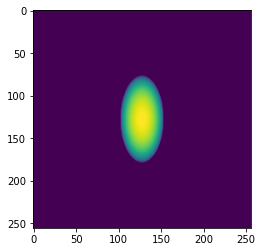

In [71]:
plt.imshow(ellipsoid.sum(-1))

In [72]:

dim3 = (1,2,3)
dim2 = (1,2)
ellipsoid_f = torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(tensor(ellipsoid).reshape(1,nx,ny,nz),dim=dim3), dim=dim3), dim=dim3)

In [73]:
central_slice_r = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(ellipsoid_f[:1,:,:,nz//2],dim=dim2),dim=dim2),dim=dim2)

In [74]:
central_slice_r.real.abs().sum(), central_slice_r.imag.abs().sum()

(tensor(416520.0625), tensor(0.1178))

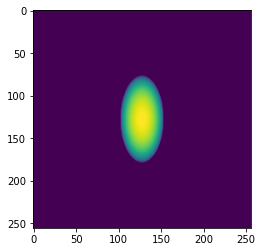

In [75]:
plt.imshow(central_slice_r[0].real)

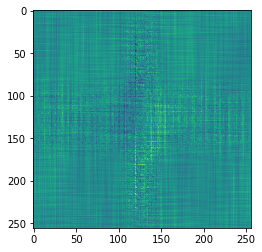

In [65]:
plt.imshow(central_slice_r[0].imag)

# Implicit -> parametric
From the implicit form for an ellipsoid, we can derive the parametric form, as a function of $z$.
$$
\frac{x^2}{a^a} + \frac{y^2}{b^2} + \frac{z^2}{c^2} = 1
\\
\implies z = \pm c \sqrt{1 - \frac{x^2}{a^a} - \frac{y^2}{b^2}}
$$

From this, we can find, for any value of x/y in the x/y plane, the value of z, which is on the surface of the ellipsoid.

Assuming the ellipsoid has constant density inside, and zero value outside, the integral is just the different of z values, above and below the x/y plane. 
* at $x=y=0$ we have $z = \pm c \sqrt{1 - 0 - 0} = \pm c$
* at $x=a/\sqrt{2}, \ y=b/\sqrt{2}$ we have $z = \pm c \sqrt{1 - 1/2 - 1/2} = 0$
* at $x=a/2, \ y=b/2$ we have $z = \pm c \sqrt{1 - 1/4 - 1/4} = \pm 1/\sqrt{2}$

We can make a numerical kernel for this.

In [102]:
#def proj_ellipsoid(x,y,a,b,step_x=1,step_y=1):
if True:
    a=20
    b=10
    step_x = step_y = 1
    x_mesh, y_mesh = np.meshgrid(np.arange(-a,a,step=step_x),np.arange(-b,b,step=step_y))
    x_mesh_2_a, y_mesh_2_b = x_mesh*x_mesh/a**2, y_mesh*y_mesh/b**2

In [107]:
z = np.sqrt(1 - x_mesh_2_a - y_mesh_2_b) # nans when sqrt (-ve)

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


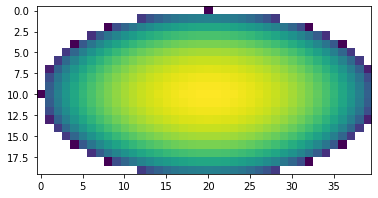

In [105]:
plt.imshow(z)

When rotating, we need to solve the implicit equation for $z$, but now with $x \rightarrow x^\prime, y \rightarrow y^\prime, z \rightarrow z^\prime$, where $[x^\prime,y^\prime,z^\prime]^T = R[x,y,z]^T$.

In other words: 
$$
1 = \frac{x^{\prime 2}}{a^a} + \frac{y^{\prime 2}}{b^2} + \frac{z^{\prime 2}}{c^2}
\\
= (Rxx \cdot x + Rxy \cdot y + Rxz \cdot z)^ 2 / a^2 + (Ryx \cdot x + Ryy \cdot y + Ryz \cdot z)^2 / b^2 + (Rzx \cdot x + Rzy \cdot y + Rzz \cdot z)^2/c^2 
$$



We can use the symbolic library `sympy` to simplify these equations, instead of doing them with pen and paper.

In [166]:
import sympy
from sympy import symbols, simplify, solve, var
# https://stackoverflow.com/questions/26787752/how-to-solve-a-simple-quadratic-equation-with-sympy
# https://docs.sympy.org/latest/modules/solvers/solveset.html#module-sympy.solvers.solveset

This example shows how to solve the get the solution to a quadratic equation in terms of the general constants, `a,b,c`. Note there are two solutions for the two roots.

In [169]:
y = 'a * x ** 2 + b * x + c'
x = var('x')
solve(y,  x )     # sympy solves Y(a,b,c,x) for x treating a, b, c as constants

[(-b - sqrt(-4*a*c + b**2))/(2*a), (-b + sqrt(-4*a*c + b**2))/(2*a)]

In [170]:
imp = 'x ** 2 / a**2 + y**2 / b**2 + z**2/c**2 - 1'
z = var('z')
sol = solve(imp,  z )
sol

[-c*sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b),
 c*sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)]

We can copy paste the solution and turn it into code with `sqrt` -> `np.sqrt`

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == "__main__":


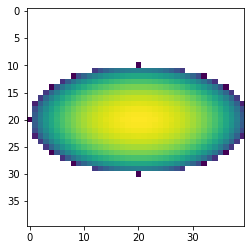

In [171]:
a=20
b=10
c=1
step_x = step_y = 1
max_axis = max(a,b)
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
def proj_non_rot(x,y,a,b,c):
    z0 = -c*np.sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)
    z1 = c*np.sqrt(a**2*b**2 - a**2*y**2 - b**2*x**2)/(a*b)
    return np.abs(z0-z1)
plt.imshow(proj_non_rot(x_mesh,y_mesh,a,b,c))

Now we can extend this to rotate the ellipsoid in the xy plane (i.e. $Rzz = 1, Rxz = Ryz = Rzx = Ryz = 0$)

In [130]:
imp = '(Rxx*x + Rxy*y)** 2 / a**2 + (Ryx*x + Ryy*y)**2 / b**2 + z**2/c**2 - 1'
z = var('z')
solve(imp,  z ) 

[-c*sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b),
 c*sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)]

/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


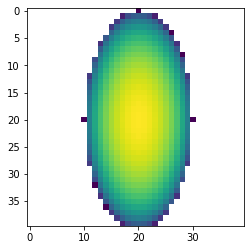

In [172]:
a=20
b=10
c=1
max_axis = max(a,b)
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
R = np.zeros((3,3))
theta = np.deg2rad(90)
c_theta = np.cos(theta)
s_theta = np.sin(theta)
R[-1,-1] = 1
R[0,:2] = c_theta, -s_theta
R[1,:2] = s_theta, c_theta

def proj_2d_rot(x,y,a,b,c,R):
    Rxx,Rxy = R[0,:2]
    Ryx,Ryy = R[1,:2]
    z0 = -c*np.sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)
    z1 =  c*np.sqrt(-Rxx**2*b**2*x**2 - 2*Rxx*Rxy*b**2*x*y - Rxy**2*b**2*y**2 - Ryx**2*a**2*x**2 - 2*Ryx*Ryy*a**2*x*y - Ryy**2*a**2*y**2 + a**2*b**2)/(a*b)
    return np.abs(z0-z1)
plt.imshow(proj_2d_rot(x_mesh,y_mesh,a,b,c,R))

In [131]:
imp = '(Rxx*x + Rxy*y + Rxz*z)** 2 / a**2 + (Ryx*x + Ryy*y + Ryz*z)**2 / b**2 + (Rzx*x + Rzy*y + Rzz*z)**2/c**2 - 1'
z = var('z')
solve(imp,  z ) 

[(-Rxx*Rxz*b**2*c**2*x - Rxy*Rxz*b**2*c**2*y - Ryx*Ryz*a**2*c**2*x - Ryy*Ryz*a**2*c**2*y - Rzx*Rzz*a**2*b**2*x - Rzy*Rzz*a**2*b**2*y - a*b*c*sqrt(-Rxx**2*Ryz**2*c**2*x**2 - Rxx**2*Rzz**2*b**2*x**2 - 2*Rxx*Rxy*Ryz**2*c**2*x*y - 2*Rxx*Rxy*Rzz**2*b**2*x*y + 2*Rxx*Rxz*Ryx*Ryz*c**2*x**2 + 2*Rxx*Rxz*Ryy*Ryz*c**2*x*y + 2*Rxx*Rxz*Rzx*Rzz*b**2*x**2 + 2*Rxx*Rxz*Rzy*Rzz*b**2*x*y - Rxy**2*Ryz**2*c**2*y**2 - Rxy**2*Rzz**2*b**2*y**2 + 2*Rxy*Rxz*Ryx*Ryz*c**2*x*y + 2*Rxy*Rxz*Ryy*Ryz*c**2*y**2 + 2*Rxy*Rxz*Rzx*Rzz*b**2*x*y + 2*Rxy*Rxz*Rzy*Rzz*b**2*y**2 - Rxz**2*Ryx**2*c**2*x**2 - 2*Rxz**2*Ryx*Ryy*c**2*x*y - Rxz**2*Ryy**2*c**2*y**2 - Rxz**2*Rzx**2*b**2*x**2 - 2*Rxz**2*Rzx*Rzy*b**2*x*y - Rxz**2*Rzy**2*b**2*y**2 + Rxz**2*b**2*c**2 - Ryx**2*Rzz**2*a**2*x**2 - 2*Ryx*Ryy*Rzz**2*a**2*x*y + 2*Ryx*Ryz*Rzx*Rzz*a**2*x**2 + 2*Ryx*Ryz*Rzy*Rzz*a**2*x*y - Ryy**2*Rzz**2*a**2*y**2 + 2*Ryy*Ryz*Rzx*Rzz*a**2*x*y + 2*Ryy*Ryz*Rzy*Rzz*a**2*y**2 - Ryz**2*Rzx**2*a**2*x**2 - 2*Ryz**2*Rzx*Rzy*a**2*x*y - Ryz**2*Rzy**2*a**2*y**2 + 

In [174]:
from scipy.spatial.transform import Rotation
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html

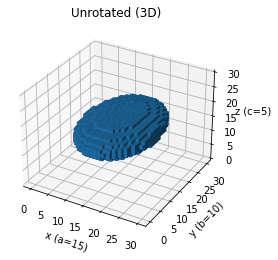

In [236]:
# prepare some coordinates
# max_dom = np.max([a,b,c])
# x, y, z = 2*np.indices((max_dom,max_dom,max_dom)) - max_dom
scale=5
a=3*scale
b=2*scale
c=1*scale
max_axis = np.max([a,b,c])
step_x = step_y = step_z = 1
x, y, z = np.meshgrid(
    np.arange(-max_axis,max_axis,step=step_x),
    np.arange(-max_axis,max_axis,step=step_y),
    np.arange(-max_axis,max_axis,step=step_z),
)


# draw cuboids in the top left and bottom right corners, and a link between
# them
ellipsoid = (x/a)**2 + (y/b)**2 + (z/c)**2
voxelarray = ellipsoid < 1

# set the colors of each object

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray)
ax.set_xlabel(f'x (a={a})')
ax.set_ylabel(f'y (b={b})')
ax.set_zlabel(f'z (c={c})')
ax.zaxis.set_rotate_label(False)
plt.title('Unrotated (3D)')

plt.show()


/Users/gw/miniconda2/envs/phys_aware_cryoem_202207/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


Text(0.5, 1.0, 'Rotated about [0 0 1] by 45 deg\n a=15,b=10,c=5')

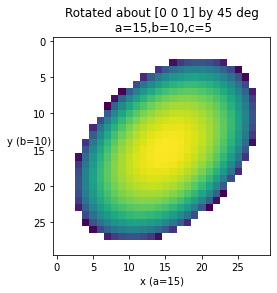

In [238]:
# a=20
# b=10
# c=5
step_x = step_y = 1
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))
axis = np.array([0,0,1])
deg=45
angle = np.deg2rad(deg)
r = Rotation.from_rotvec(angle*axis).as_matrix()

def proj_3d_rot(x,y,a,b,c,r):
    Rxx,Rxy,Rxz = r[0]
    Ryx,Ryy,Ryz = r[1]
    Rzx,Rzy,Rzz = r[2]
    # note that the z0 and z1 terms are very similar, except for a sign, so we can precompute the pieces 
    piece_1 = (-Rxx*Rxz*b**2*c**2*x - Rxy*Rxz*b**2*c**2*y - Ryx*Ryz*a**2*c**2*x - Ryy*Ryz*a**2*c**2*y - Rzx*Rzz*a**2*b**2*x - Rzy*Rzz*a**2*b**2*y)
    piece_2 = a*b*c*np.sqrt(-Rxx**2*Ryz**2*c**2*x**2 - Rxx**2*Rzz**2*b**2*x**2 - 2*Rxx*Rxy*Ryz**2*c**2*x*y - 2*Rxx*Rxy*Rzz**2*b**2*x*y + 2*Rxx*Rxz*Ryx*Ryz*c**2*x**2 + 2*Rxx*Rxz*Ryy*Ryz*c**2*x*y + 2*Rxx*Rxz*Rzx*Rzz*b**2*x**2 + 2*Rxx*Rxz*Rzy*Rzz*b**2*x*y - Rxy**2*Ryz**2*c**2*y**2 - Rxy**2*Rzz**2*b**2*y**2 + 2*Rxy*Rxz*Ryx*Ryz*c**2*x*y + 2*Rxy*Rxz*Ryy*Ryz*c**2*y**2 + 2*Rxy*Rxz*Rzx*Rzz*b**2*x*y + 2*Rxy*Rxz*Rzy*Rzz*b**2*y**2 - Rxz**2*Ryx**2*c**2*x**2 - 2*Rxz**2*Ryx*Ryy*c**2*x*y - Rxz**2*Ryy**2*c**2*y**2 - Rxz**2*Rzx**2*b**2*x**2 - 2*Rxz**2*Rzx*Rzy*b**2*x*y - Rxz**2*Rzy**2*b**2*y**2 + Rxz**2*b**2*c**2 - Ryx**2*Rzz**2*a**2*x**2 - 2*Ryx*Ryy*Rzz**2*a**2*x*y + 2*Ryx*Ryz*Rzx*Rzz*a**2*x**2 + 2*Ryx*Ryz*Rzy*Rzz*a**2*x*y - Ryy**2*Rzz**2*a**2*y**2 + 2*Ryy*Ryz*Rzx*Rzz*a**2*x*y + 2*Ryy*Ryz*Rzy*Rzz*a**2*y**2 - Ryz**2*Rzx**2*a**2*x**2 - 2*Ryz**2*Rzx*Rzy*a**2*x*y - Ryz**2*Rzy**2*a**2*y**2 + Ryz**2*a**2*c**2 + Rzz**2*a**2*b**2)
    piece_3 = (Rxz**2*b**2*c**2 + Ryz**2*a**2*c**2 + Rzz**2*a**2*b**2)
    z0 = (piece_1 - piece_2) / piece_3
    z1 = (piece_1 + piece_2) / piece_3
    return 2*piece_2/piece_3

plt.imshow(proj_3d_rot(x_mesh,y_mesh,a,b,c,r))
plt.xlabel(f'x (a={a})')
plt.ylabel(f'y (b={b})',rotation=0)
plt.title(f'Rotated about {axis} by {deg} deg\n a={a},b={b},c={c}')

# rotated circle
$$
x^2 + y^2 = r_c^2
\\
R(x, y, z)^T = (R_{xx}x + R_{xy}y + R_{xz}z, R_{yx}x + R_{yy}y + R_{yz}z, ...)^T = (x^\prime,y^\prime,z^\prime)^T
\\
{x^{\prime}}^2 + {y^{\prime}}^2 = r_c^2
$$

In [1395]:
# rotation = Rotation.from_euler('ZYX',[0,45,-45],degrees=True).as_matrix()
rotation = Rotation.from_euler('XZY',[0,0,45],degrees=True).as_matrix()
rotation

array([[ 0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.        ,  0.70710678]])

In [1402]:
a,b = 1, 1
step_x = step_y = 0.01
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))

rad_mesh = np.hypot(x_mesh,y_mesh)
theta_mesh = np.arctan2(y_mesh,x_mesh)

Text(0.5, 1.0, 'Projected circle (rotated to x=y axis)')

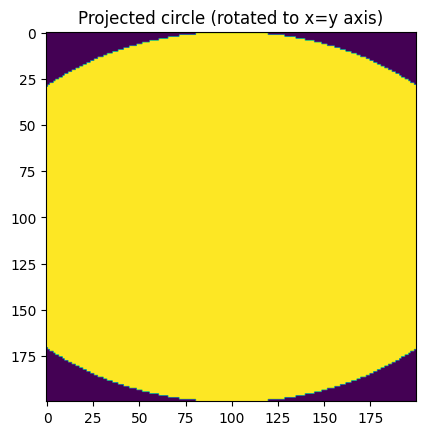

In [1401]:
def rotated_circle(x,y,radius_circle,rotation):
    Rxx,Rxy,Rxz = rotation[0]
    Ryx,Ryy,Ryz = rotation[1]
    Rzx,Rzy,Rzz = rotation[2]
    z=0 # project to plane, so fix z coordinate to zero
#     assert np.allclose((Ryx*x+Ryy*y+Ryz*z),y)
#     return (Rxx*x+Rxy*y+Rxz*z)**2 + (Ryx*x+Ryy*y+Ryz*z)**2 < radius_circle**2
    
     return (Rxx*x+Rxy*y+Rxz*z)**2 + (Ryx*x+Ryy*y+Ryz*z)**2 < 1


circ = rotated_circle(x=x_mesh,y=y_mesh,radius_circle=1,rotation=rotation)

plt.imshow(circ)
plt.title('Projected circle (rotated to x=y axis)')

# rotated circle etc

In [1132]:
# imp = '(Rxx*x + Rxy*y + Rxz*z)** 2 + (Ryx*x + Ryy*y + Ryz*z)**2  - 1'
# z = var('z')
# solve(imp,  z ) 

In [12]:
axis = np.array([1,1,1])
axis = axis/np.linalg.norm(axis)
deg=45
angle = np.deg2rad(deg)
r = Rotation.from_rotvec(angle*axis).as_matrix()

In [39]:
Rx = Rotation.from_euler('zyx',[0,0,np.pi/8]).as_matrix()
Ry = Rotation.from_euler('zyx',[0,np.pi/4,0]).as_matrix()
Rxy = Rotation.from_euler('zyx',[0,np.pi/4,np.pi/8]).as_matrix()
np.allclose(Rx@Ry,Rxy)

True

In [40]:
theta_z,theta_y,theta_x = Rotation.from_matrix(Rxy).as_euler('zyx')

In [41]:
theta_y,theta_x

(0.7853981633974483, 0.39269908169872414)

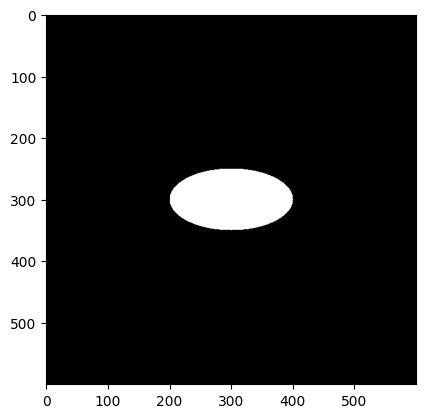

In [193]:
a,b = 3,3

step_x = step_y = 0.01
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))


def implicit_ellipse(x,y,a=1,b=1):
    return (x/a)**2 + (y/b)**2 < 1

plt.imshow(implicit_ellipse(x_mesh, y_mesh,a=1,b=0.5),cmap='gray')

In [81]:
def proj_rotated_circle(x,y,radius_circle,rotation):
    _,theta_y,theta_x = Rotation.from_matrix(rotation).as_euler('zyx')
    return implicit_ellipse(x,y,a=radius_circle*np.cos(theta_y),b=radius_circle*np.cos(theta_x))
    

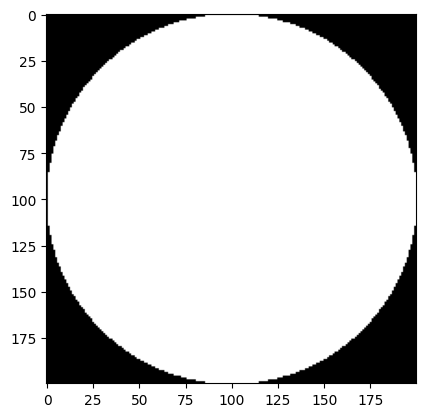

In [83]:
Rxy = Rotation.from_euler('zyx',[0,0,0]).as_matrix()
ellipse = proj_rotated_circle(x_mesh, y_mesh,radius_circle=1,rotation=Rxy)
plt.imshow(ellipse,cmap='gray')

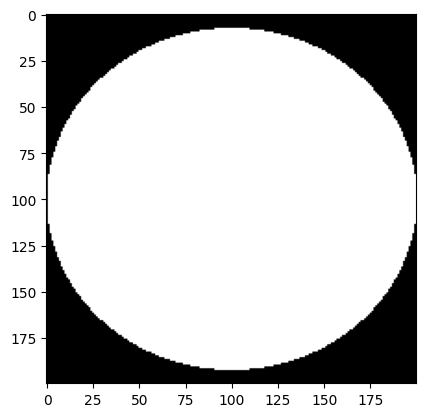

In [128]:
Rxy = Rotation.from_euler('zyx',[0,0,np.pi/8]).as_matrix()
ellipse = proj_rotated_circle(x_mesh, y_mesh,radius_circle=1,rotation=Rxy)
plt.imshow(ellipse,cmap='gray')

## project translated circle
* Rotation of translated point is $R(p+t) = Rp + Rt$, so projection of rotated object the same, just translated differently
* In our case $t^T = (0,0,\delta z)$, thus we can just translate the circle after the projection, or have the mesh points taking into account the translation
* https://math.stackexchange.com/questions/1695463/translation-followed-by-rotation

In [545]:
a,b = 5,5

step_x = step_y = 0.05
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))


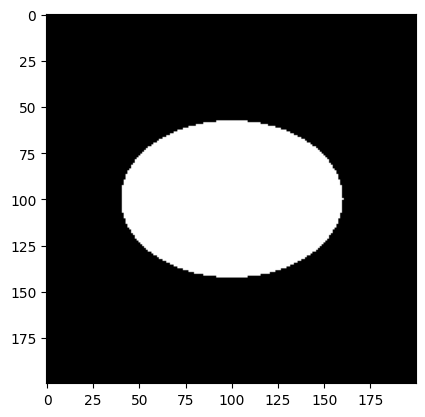

In [546]:
Rxy = Rotation.from_euler('zyx',[0,0,np.pi/4]).as_matrix()

def proj_rotated_translated_circle(x_mesh, y_mesh,radius_circle,rotation,translation):
    x_trans, y_trans, _ = rotation@translation
    ellipse = proj_rotated_circle(x_mesh-x_trans, y_mesh-y_trans,radius_circle,rotation) # TODO: check plus or minus translation
    return ellipse

ellipse = proj_rotated_translated_circle(x_mesh, y_mesh,radius_circle=3,rotation=Rxy,translation=np.array([0,0,0]))
plt.imshow(ellipse,cmap='gray')

In [547]:
Rxy = Rotation.from_euler('zyx',[0,np.pi/4,np.pi/8]).as_matrix()
rotation = Rxy
translation=np.array([0,0,0.1])
rotation@translation

array([ 0.07071068, -0.02705981,  0.06532815])

In [548]:
rotation[:,-1]*translation[-1]

array([ 0.07071068, -0.02705981,  0.06532815])

## project cylindar
* break into regions

In [479]:
a,b = 5,5

step_x = step_y = 0.05
max_axis = np.max([a,b])
x_mesh, y_mestheta_top_left = np.arctan2(height_cylindar/2,-radius_circle)
theta_bottom_right = np.arctan2(-height_cylindar/2,radius_circle)

top_left = np.cos(theta_top_left - angle_from_z)
bottom_right = np.cos(theta_bottom_right - angle_from_z)
assert top_left > bottom_right
assert theta_top_left - angle_from_z < np.pi/2h = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))


In [627]:
rotation = Rotation.from_euler('zyx',[0,0,80],degrees=True).as_matrix()
_,theta_y,theta_x = Rotation.from_matrix(rotation).as_euler('zyx')
rotation = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_matrix()

r = np.hypot(x_mesh, y_mesh)

axis = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_rotvec()
angle_from_z = np.linalg.norm(axis)
np.rad2deg(angle_from_z)

79.99999999999999

### Check top left/right crossed over bottom left/right

In [656]:
radius_circle = 4
height_cylindar = 4

In [657]:
theta_top_left = np.arctan2(height_cylindar/2,-radius_circle)
theta_bottom_right = np.arctan2(-height_cylindar/2,radius_circle)

top_left = np.cos(theta_top_left - angle_from_z)
bottom_right = np.cos(theta_bottom_right - angle_from_z)
assert top_left > bottom_right
assert theta_top_left - angle_from_z < np.pi/2

In [658]:
# geodesic_theta = 2*np.arcsin(np.linalg.norm(rotation - np.eye(3)) / (2*np.sqrt(2)))

In [659]:

# h_inner = 2*radius_circle*np.cos(np.pi/2-angle_from_z)
h_inner_scalar = np.abs(2*radius_circle*(np.sin(angle_from_z) + np.cos(angle_from_z)**2/np.sin(angle_from_z)))
l = np.abs(2*radius_circle*np.cos(angle_from_z) - height_cylindar*np.sin(angle_from_z)) # TODO: check cases based on +/- sign
# theta = np.pi/2 - angle_from_z
# np.isclose(l,2*radius_circle*np.sin(theta) - h*np.cos(theta))

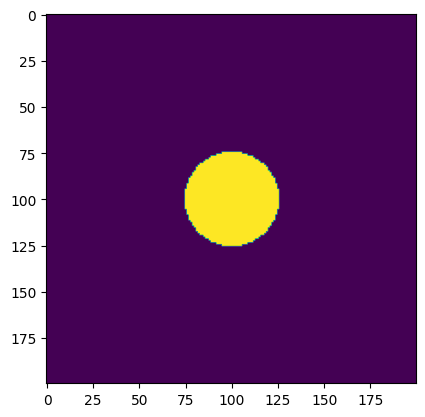

In [660]:
inner_bool = (r < l/2)
h_inner = h_inner_scalar*inner_bool
plt.imshow(h_inner)

In [661]:
l3 = 2*radius_circle*np.cos(angle_from_z)
s = (r-l/2-l3) / (-l3)
l3

1.389185421335445

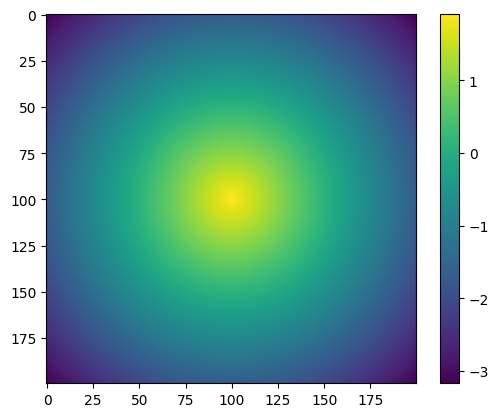

In [662]:
ax = plt.imshow(s)
plt.colorbar(ax)

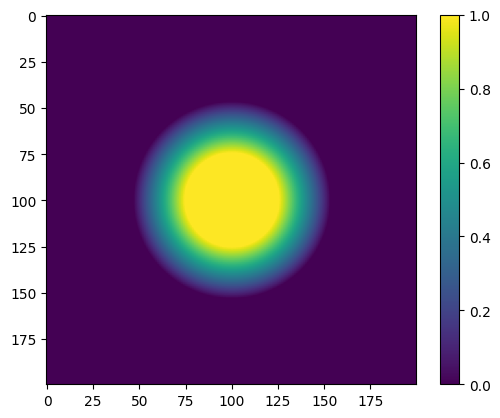

In [663]:
ax = plt.imshow(s,vmin=0,vmax=1)
plt.colorbar(ax)

In [664]:
s_bool = np.logical_and(0 < s, s < 1)
s_edge = s * s_bool

In [665]:
h_top = 2*s_edge*radius_circle*np.sqrt(1 - np.cos(angle_from_z)**2)
h_bottom = s_edge*np.sqrt((h_inner_scalar**2 - (2*radius_circle)**2*(1 + np.cos(angle_from_z)**2)))
h_outer = h_top + h_bottom

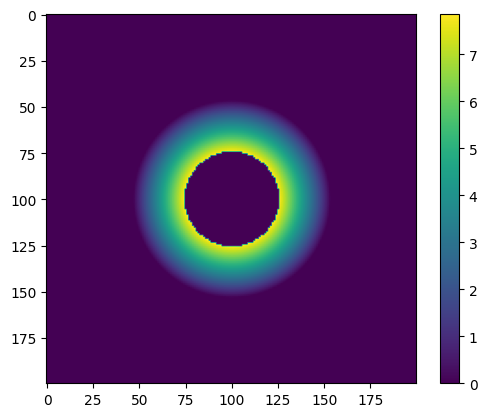

In [666]:
ax = plt.imshow(h_top)
plt.colorbar(ax)

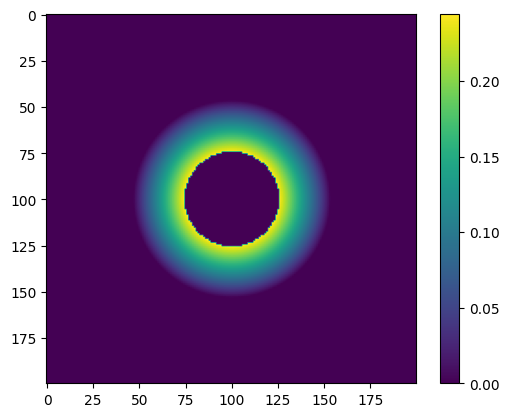

In [667]:
ax = plt.imshow(h_bottom)
plt.colorbar(ax)

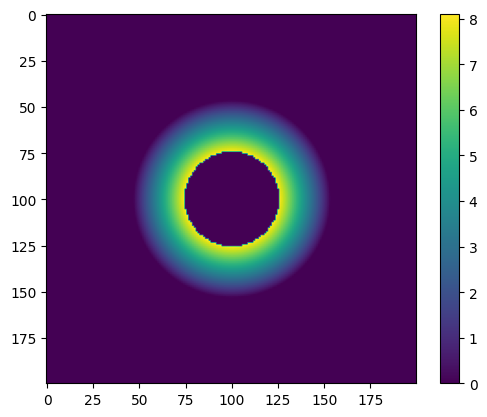

In [668]:
ax = plt.imshow(h_outer)
plt.colorbar(ax)

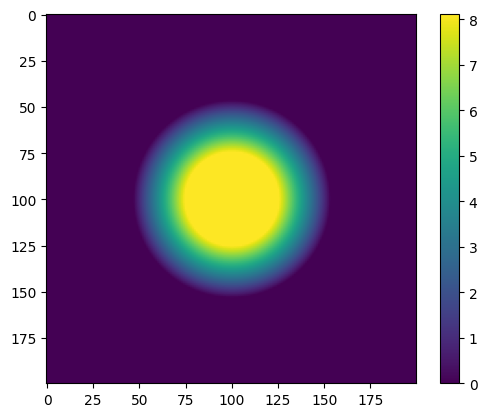

In [669]:
proj_cylindar = h_inner + h_outer
ax = plt.imshow(proj_cylindar)
plt.colorbar(ax)

### Alternative case where points don't cross

In [776]:
a,b = 5,5

step_x = step_y = 0.05
max_axis = np.max([a,b])
x_mesh, y_mesh = np.meshgrid(np.arange(-max_axis,max_axis,step=step_x),np.arange(-max_axis,max_axis,step=step_y))


In [893]:
rotation = Rotation.from_euler('zyx',[0,0,45],degrees=True).as_matrix()
_,theta_y,theta_x = Rotation.from_matrix(rotation).as_euler('zyx')
rotation = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_matrix()

r = np.hypot(x_mesh, y_mesh)

axis = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_rotvec()
angle_from_z = np.linalg.norm(axis)
np.rad2deg(angle_from_z)

45.00000000000001

In [894]:
radius_circle = 1
height_cylindar = 2

In [895]:
theta_top_left = np.arctan2(height_cylindar/2,-radius_circle)
theta_bottom_right = np.arctan2(-height_cylindar/2,radius_circle)

top_left = np.cos(theta_top_left - angle_from_z)
bottom_right = np.cos(theta_bottom_right - angle_from_z)
assert top_left <= bottom_right
assert theta_top_left - angle_from_z >= np.pi/2

In [896]:
l3 = np.abs(height_cylindar*np.sin(angle_from_z))


In [906]:
l3

1.4142135623730951

In [907]:
r = np.sqrt((height_cylindar/2)**2 + radius_circle**2)
theta_start = np.arccos(radius_circle/r)


In [908]:
l3_half = r*np.cos(theta_start - angle_from_z) - radius_circle
2*l3_half

0.8284271247461903

In [900]:
np.isclose(l3, 2*l3_half)

False

In [904]:
l = r*np.cos(theta_start-angle_from_z) - l3 # previous l/2 for other case
print(l)
assert l > 0 # TODO: check why negative

0.0


AssertionError: 

In [905]:
l = r*np.cos(theta_start-angle_from_z) - l3_half*2 # previous l/2 for other case
assert l > 0 # TODO: check why negative
l

0.5857864376269049

In [754]:
h_inner_scalar = np.abs(height_cylindar*(np.cos(angle_from_z) + np.sin(angle_from_z)**2/np.cos(angle_from_z)))

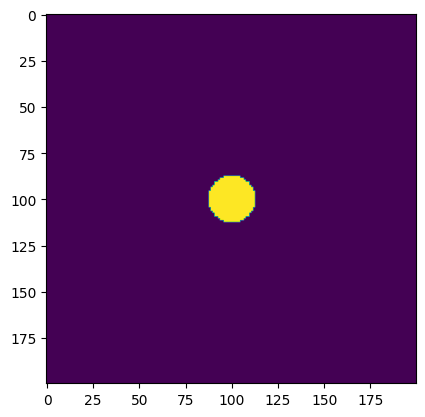

In [755]:
inner_bool = (r < l)
h_inner = h_inner_scalar*inner_bool
plt.imshow(h_inner)

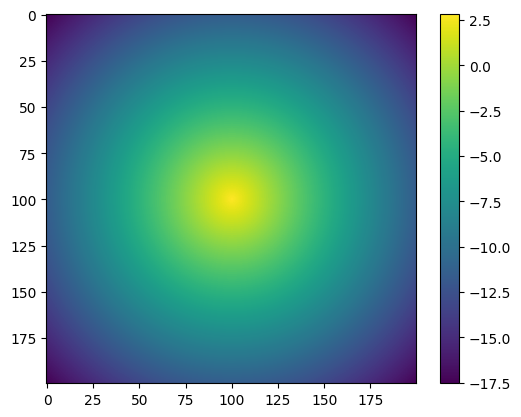

In [756]:
s = (r-l-l3) / (-l3)
ax = plt.imshow(s)
plt.colorbar(ax)

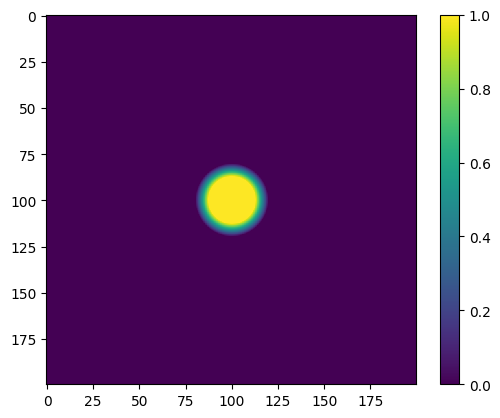

In [757]:
ax = plt.imshow(s,vmin=0,vmax=1)
plt.colorbar(ax)

In [763]:
s_bool = np.logical_and(0 < s, s < 1)
s_edge = s * s_bool

In [764]:
h_top = s_edge*height_cylindar*np.sqrt(1 - np.sin(angle_from_z)**2)
h_bottom = s_edge*np.sqrt((h_inner_scalar**2 - (height_cylindar)**2*(1 + np.sin(angle_from_z)**2)))
h_outer = h_top + h_bottom

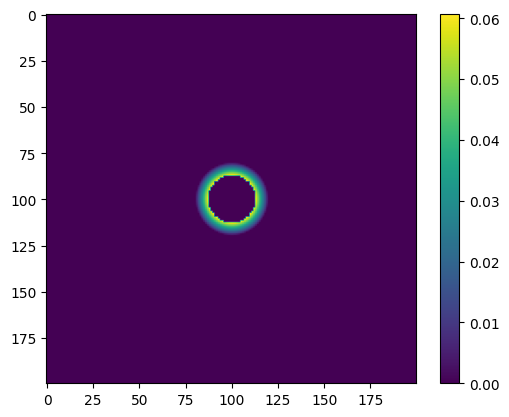

In [765]:
ax = plt.imshow(h_bottom)
plt.colorbar(ax)

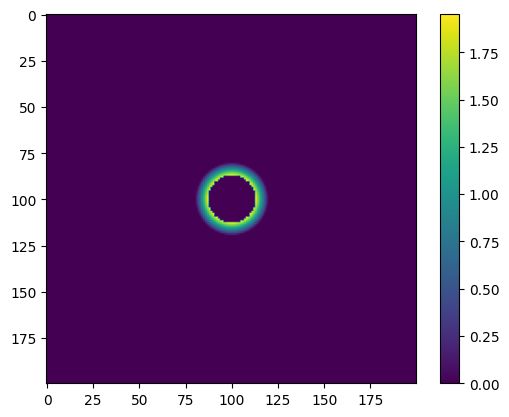

In [767]:
ax = plt.imshow(h_top)
plt.colorbar(ax)

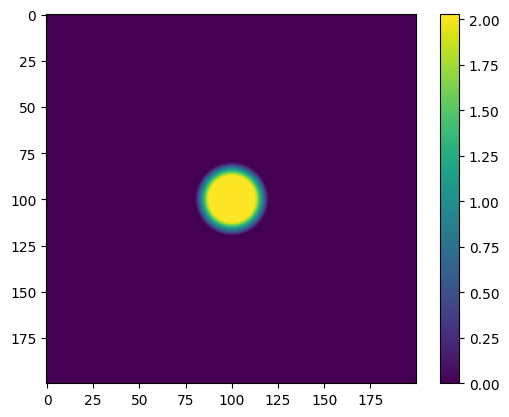

In [768]:
proj_cylindar = h_inner + h_outer
ax = plt.imshow(proj_cylindar)
plt.colorbar(ax)

### wrap into function

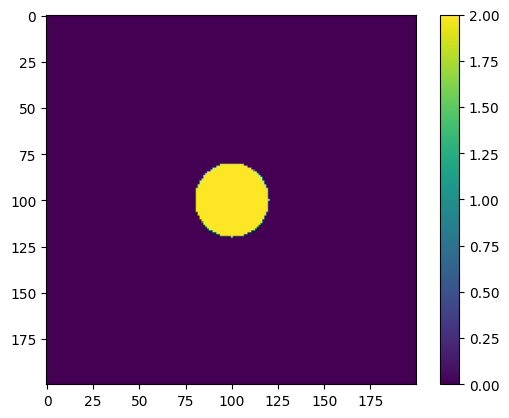

In [939]:
rotation = Rotation.from_euler('zyx',[0,0,90],degrees=True).as_matrix()
radius_circle = 1
height_cylindar = 2

def project_rotated_cylindar(x_mesh, y_mesh,radius_circle,height_cylindar,rotation):
    r = np.hypot(x_mesh, y_mesh)

    _,theta_y,theta_x = Rotation.from_matrix(rotation).as_euler('zyx')
    rotation = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_matrix()

    axis = Rotation.from_euler('zyx',[0,theta_y,theta_x]).as_rotvec()
    angle_from_z = np.linalg.norm(axis)
    
    theta_top_left = np.arctan2(height_cylindar/2,-radius_circle)
    theta_bottom_right = np.arctan2(-height_cylindar/2,radius_circle)

    top_left = np.cos(theta_top_left - angle_from_z)
    bottom_right = np.cos(theta_bottom_right - angle_from_z)
    
    if np.isclose(angle_from_z,0):
        case = 'close to zero'
        circle_bool = r <= radius_circle
        proj_cylindar = circle_bool*height_cylindar
        return proj_cylindar, case
    
    elif top_left <= bottom_right: # small rotation case (not tipped over)
        case = 'upright'
        assert theta_top_left - angle_from_z >= np.pi/2
        
        l3 = np.abs(height_cylindar*np.sin(angle_from_z))
        radius_top_right = np.sqrt((height_cylindar/2)**2 + radius_circle**2)
        theta_start = np.arccos(radius_circle/radius_top_right)
        l = radius_top_right*np.cos(theta_start-angle_from_z) - l3 # previous l/2 for other case
        assert l >= 0 # TODO: check why negative

        h_inner_scalar = np.abs(height_cylindar*(np.cos(angle_from_z) + np.sin(angle_from_z)**2/np.cos(angle_from_z)))
        
        inner_bool = (r < l)
        h_inner = h_inner_scalar*inner_bool
        
        s = (r-l-l3) / (-l3)
        s_bool = np.logical_and(0 < s, s < 1)
        s_edge = s * s_bool
        
        h_top = s_edge*height_cylindar*np.sqrt(1 - np.sin(angle_from_z)**2)
        h_bottom = s_edge*np.sqrt((h_inner_scalar**2 - (height_cylindar)**2*(1 + np.sin(angle_from_z)**2)))

    else: # tipped over
        case = 'tipped over'
        assert theta_top_left - angle_from_z < np.pi/2
        
        h_inner_scalar = np.abs(2*radius_circle*(np.sin(angle_from_z) + np.cos(angle_from_z)**2/np.sin(angle_from_z)))
        l = np.abs(radius_circle*np.cos(angle_from_z) - height_cylindar/2*np.sin(angle_from_z)) # TODO: check cases based on +/- sign

        inner_bool = (r < l)
        h_inner = h_inner_scalar*inner_bool
        
        l3 = 2*radius_circle*np.cos(angle_from_z)
        s = (r-l-l3) / (-l3)
        s_bool = np.logical_and(0 < s, s < 1)
        s_edge = s * s_bool

        h_top = 2*s_edge*radius_circle*np.sqrt(1 - np.cos(angle_from_z)**2)
        h_bottom = s_edge*np.sqrt((h_inner_scalar**2 - (2*radius_circle)**2*(1 + np.cos(angle_from_z)**2)))
    
    h_outer = h_top + h_bottom
    proj_cylindar = h_inner + h_outer
    return proj_cylindar, case

proj_cylindar, case = project_rotated_cylindar(x_mesh, y_mesh,radius_circle,height_cylindar,rotation)
ax = plt.imshow(proj_cylindar)
plt.colorbar(ax)

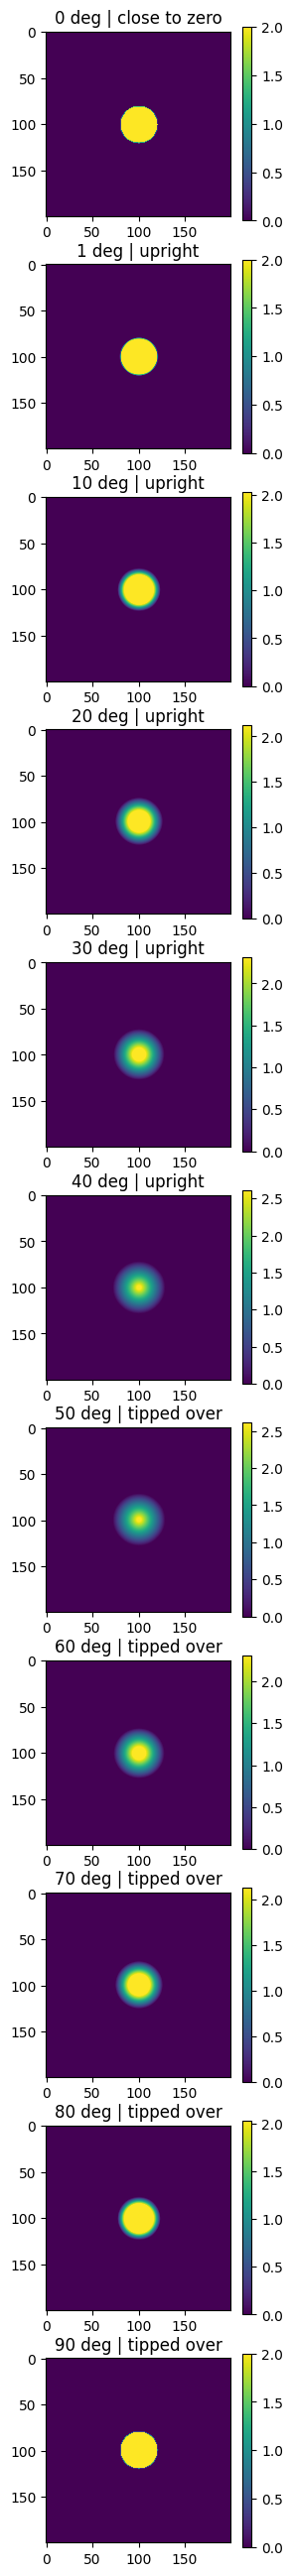

In [940]:
radius_circle = 1
height_cylindar = 2
tilt_angle_degs = [0,1,10,20,30,40,50,60,70,80,90]

fig, axes = plt.subplots(nrows=len(tilt_angle_degs),figsize=(3,3*len(tilt_angle_degs)))
for idx, tilt_angle_deg in enumerate(tilt_angle_degs):
    rotation = Rotation.from_euler('zyx',[0,0,tilt_angle_deg],degrees=True).as_matrix()
    proj_cylindar, case = project_rotated_cylindar(x_mesh, y_mesh,radius_circle,height_cylindar,rotation)
    ax = axes[idx].imshow(proj_cylindar)
    axes[idx].set_title(f'{tilt_angle_deg} deg | {case}')
    plt.colorbar(ax)
    

Thinking about things more, this isn't at all what I wanted ... it does not even look like a cylindar!

# Project cylindar
* convolve line with circle

Text(0.5, 1.0, 'Line segment')

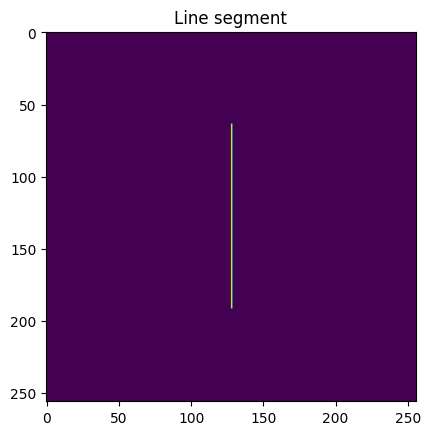

In [2]:
n=256
line_stright = torch.zeros(n,n)
line_stright[:,n//2] = 1
n_border_straight = n//4
line_stright[:n_border_straight,:] = line_stright[-n_border_straight:,:] = line_stright[:,:n_border_straight] = line_stright[:,-n_border_straight:] = 0
plt.imshow(line_stright.numpy())
plt.title('Line segment')


Text(0.5, 1.0, 'FT of line segment')

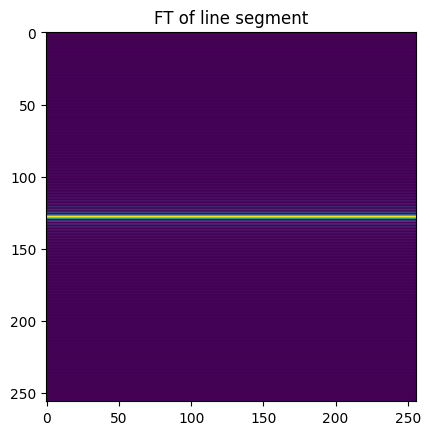

In [3]:
line_stright_f = transforms.fourier_to_primal_2D(line_stright)
plt.imshow(line_stright_f.abs())
plt.title('FT of line segment')


In [4]:
arr_1d = torch.arange(-n//2,n//2,1).float()
y_mesh, x_mesh = torch.meshgrid(arr_1d,arr_1d)

In [5]:
rotation = Rotation.from_euler('XYZ',[45,45,0],degrees=True).as_matrix()
rotated_zaxis = rotation[:,-1]
slope = rotated_zaxis[1] / rotated_zaxis[0]
slope
# hard code cases for 0 slope and infinity slope to stright line (horizintal / vertical)

-0.7071067811865475

Text(0.5, 1.0, 'Line segment (see zig-zag artefacts)')

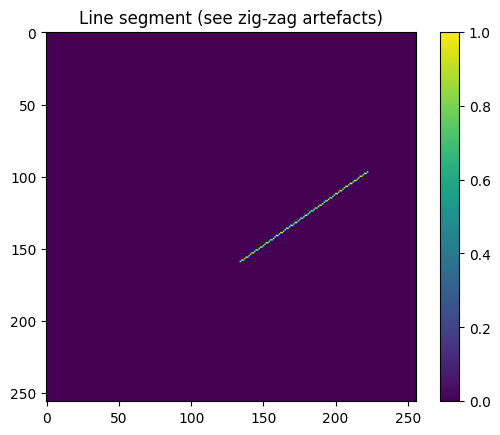

In [15]:
#line_test = rotated_zaxis[0]*y_mesh - rotated_zaxis[1]*x_mesh
shift_x, shift_y = 50, 0
line_test = (y_mesh-shift_y) - slope*(x_mesh-shift_x)

line = torch.isclose(line_test,torch.zeros_like(line_test),atol=0.5)
# n_border = int((n - (n - 2*n_border_straight)/np.sqrt(2))//2) 45 45 
h = n//2
Rxz, Ryz = rotation[[0,1],-1] 
n_border_x = int(np.round(n/2 - h/2*np.abs(Rxz) - shift_x))
n_border_y = int(np.round(n/2 - h/2*np.abs(Ryz) - shift_y))

line[:n_border_y,:] = line[-n_border_y:,:] = line[:,:n_border_x] = line[:,-n_border_x:] = 0 # fails if n_border 0
ax = plt.imshow(line)
plt.colorbar(ax)
plt.title('Line segment (see zig-zag artefacts)')

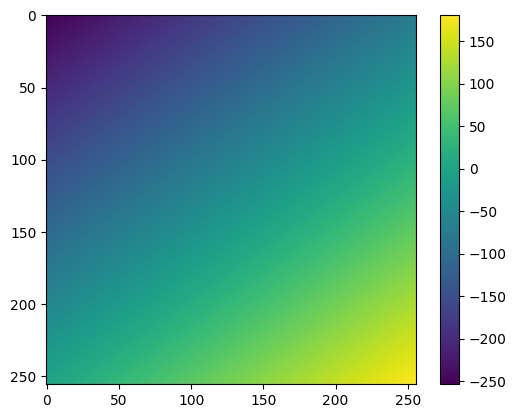

In [16]:
ax = plt.imshow(line_test)
plt.colorbar(ax)

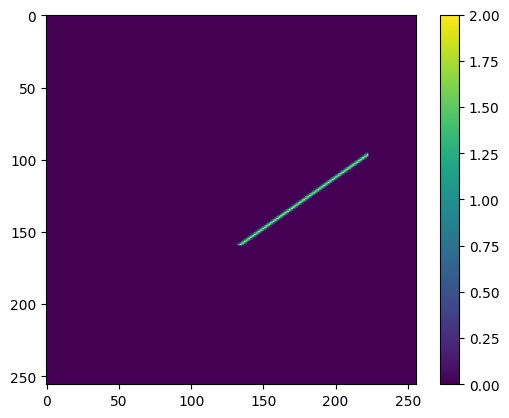

In [17]:
a_max = 2
line_clipped = a_max - np.clip(np.abs(line_test),a_min=0,a_max=a_max)
line_clipped[:n_border_y,:] = line_clipped[-n_border_y:,:] = line_clipped[:,:n_border_x] = line_clipped[:,-n_border_x:] = 0 # fails if n_border 0
ax = plt.imshow(line_clipped)
plt.colorbar(ax)

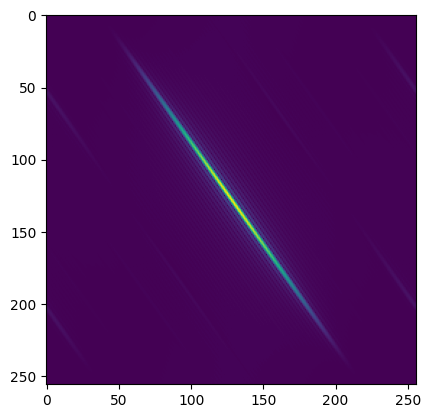

In [18]:
line_f = transforms.primal_to_fourier_2D(line_clipped)
plt.imshow(line_f.abs())

In [1785]:
# rad_mesh = torch.hypot(y_mesh,x_mesh)

Text(0.5, 1.0, 'Ellipse')

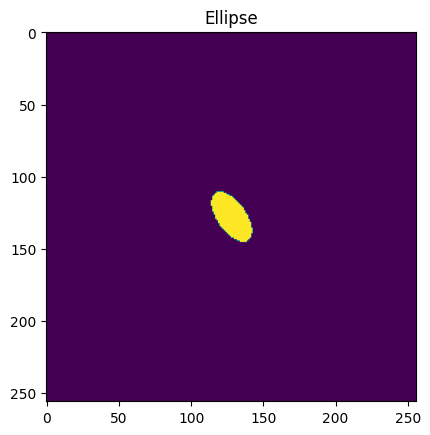

In [34]:
a, b = 40, 10
ellipse_straight = (x_mesh/a)**2 + (y_mesh/b)**2 < 1
shift_x, shift_y = 0, 0
ellipse = projected_rotated_circle(x=x_mesh-shift_x,y=y_mesh-shift_y,radius_circle=20,rotation=rotation)

plt.imshow(ellipse.numpy())
plt.title('Ellipse')


In [21]:
ellipse_stright_f = transforms.primal_to_fourier_2D(ellipse_straight)
ellipse_f = transforms.primal_to_fourier_2D(ellipse)

Text(0.5, 1.0, 'FT of ellipse')

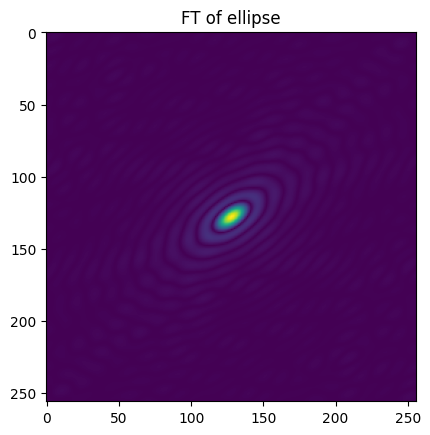

In [22]:
plt.imshow(ellipse_f.abs())
plt.title('FT of ellipse')

In [23]:
convolve = transforms.fourier_to_primal_2D(ellipse_f*line_f)
convolve_stright = transforms.fourier_to_primal_2D(ellipse_stright_f*line_stright_f)

Text(0.5, 1.0, 'Projected cylindar (via convolution)')

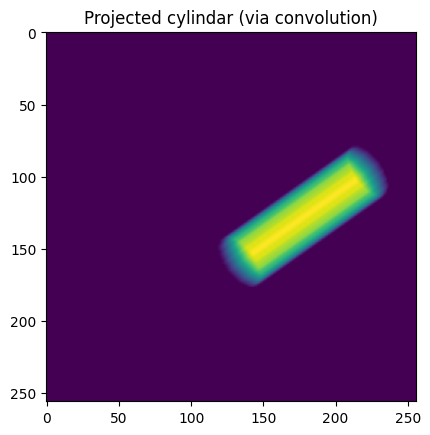

In [24]:
plt.imshow(convolve.real.numpy())
plt.title('Projected cylindar (via convolution)')

In [1792]:
from scipy.ndimage import rotate

interpolated = rotate(convolve_stright.real.numpy(),angle=-45,reshape=False)

Text(0.5, 1.0, 'Projected cylindar (scipy.ndimage.rotate from upright)')

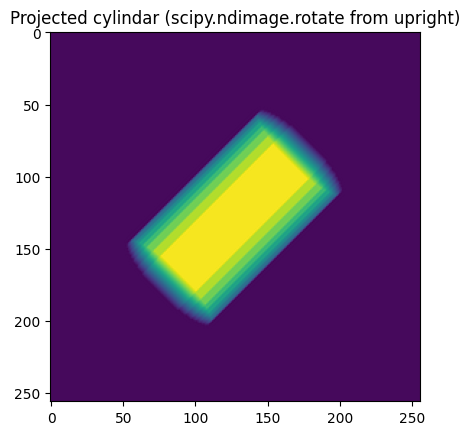

In [1793]:
plt.imshow(interpolated)
plt.title('Projected cylindar (scipy.ndimage.rotate from upright)')

Text(0.5, 1.0, 'Projected cylindar (upright)')

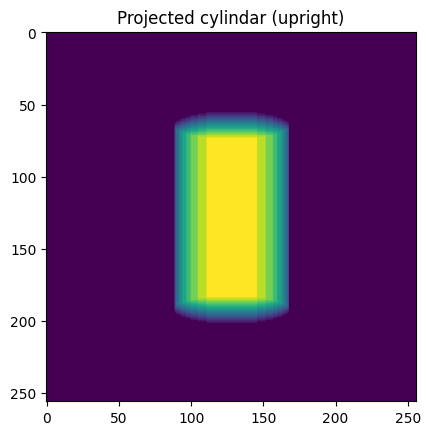

In [1324]:
plt.imshow(convolve_stright.real.numpy())
plt.title('Projected cylindar (upright)')

# `project_rotated_cylinder` src and tests

In [10]:
# def project_rotated_cylinder(x,y,radius_circle,h, rotation):
#     '''
#     h in units of pixels
    
#     TODO: h=0 case still shows thin line
#     [45,90,0] fails
#     '''
#     # project rotated z axis onto xy plane, get slope
#     assert x.shape == y.shape
#     n = x.shape[0]
#     Rxz, Ryz, Rzz = rotation[:,-1]

#     if np.isclose(rotation[-1,-1],1,atol=1e-4):
#         case = 'about z-axis'
#         circle = projected_rotated_circle(x,y,radius_circle,rotation=np.eye(3))
#         fill_factor = h
#         proj_cylinder = fill_factor*circle
#         print(case)
#         return proj_cylinder
    
#     ## TODO: case of flat line up or sideways
    
#     elif np.isclose(np.abs(Rxz),1): # 90 deg, line along y-axis
#         case = '90 deg, line along x-axis'
#         line = torch.zeros(n,n)
#         line[n//2,:] = 1
#         n_border_x = int(np.round(n/2 - h/2))
#         line[:,:n_border_x] = line[:,-n_border_x:] = 0 

        
#     elif np.isclose(np.abs(Ryz),1): # 
#         case = '90 deg, line along y-axis'
#         line = torch.zeros(n,n)
#         line[:,n//2] = 1
#         n_border_y = int(np.round(n/2 - h/2))
#         line[:n_border_y,:] = line[-n_border_y:,:] = 0 

#     elif np.isclose(Ryz,0) and not np.isclose(Rzz,1): 
#         case = '90 deg, line along x-axis with z-tilt'
#         line = torch.zeros(n,n)
#         line[n//2,:] = 1
#         n_border_x = int(np.round(n/2 - h/2*np.abs(Rxz)))
#         line[:,:n_border_x] = line[:,-n_border_x:] = 0 
        
#     elif np.isclose(Rxz,0) and not np.isclose(Rzz,1): 
#         case = '90 deg, line along y-axis with z-tilt'
#         line = torch.zeros(n,n)
#         line[:,n//2] = 1
#         n_border_y = int(np.round(n/2 - h/2*np.abs(Ryz)))
#         line[:n_border_y,:] = line[-n_border_y:,:] = 0 
    
#     else:
#         case = 'else'
#         line_test = Rxz*y - Ryz*x # intercept zero since cylinder centered

#         line_width_factor = 2
#         line_clipped = line_width_factor - np.clip(np.abs(line_test),a_min=0,a_max=line_width_factor)

#         n_border_x = int(np.round(n/2 - h/2*np.abs(Rxz)))
#         n_border_y = int(np.round(n/2 - h/2*np.abs(Ryz)))
# #         n_border_x = int(np.clip(np.round(n/2 - h/2*np.abs(Rxz)),a_min=1,a_max=n//2-1))
# #         n_border_y = int(np.clip(np.round(n/2 - h/2*np.abs(Ryz)),a_min=1,a_max=n//2-1))

#         line_clipped[:n_border_y,:] = line_clipped[-n_border_y:,:] = line_clipped[:,:n_border_x] = line_clipped[:,-n_border_x:] = 0 # fails if n_border 0
#         line = line_clipped
        
#     line_f = transforms.primal_to_fourier_2D(line)

#     ellipse = projected_rotated_circle(x,y,radius_circle,rotation)
#     ellipse_f = transforms.primal_to_fourier_2D(ellipse)
#     convolve = transforms.fourier_to_primal_2D(ellipse_f*line_f)
#     proj_cylinder = convolve.real.numpy()
#     print(case)
#     return proj_cylinder

def project_rotated_cylinder(x, y, radius_circle, h, rotation):
  '''
  h in units of pixels

  TODO: h=0 case still shows thin line
  'ZYX',[45,90,0] else case fails
  '''
  assert x.shape == y.shape
  n = x.shape[0]
  Rxz, Ryz, Rzz = rotation[:, -1]

  if np.isclose(rotation[-1, -1], 1, atol=1e-4):
    case = 'about z-axis'
    circle = projected_rotated_circle(x, y, radius_circle, rotation=np.eye(3))
    fill_factor = h
    proj_cylinder = fill_factor * circle
    print(case)
    return proj_cylinder

  elif np.isclose(np.abs(Rxz), 1):  # 90 deg, line along y-axis
    case = '90 deg, line along x-axis'
    line = torch.zeros(n, n)
    line[n // 2, :] = 1
    n_border_x = int(np.round(n / 2 - h / 2))
    line[:, :n_border_x] = line[:, -n_border_x:] = 0


  elif np.isclose(np.abs(Ryz), 1):  #
    case = '90 deg, line along y-axis'
    line = torch.zeros(n, n)
    line[:, n // 2] = 1
    n_border_y = int(np.round(n / 2 - h / 2))
    line[:n_border_y, :] = line[-n_border_y:, :] = 0

  elif np.isclose(Ryz, 0) and not np.isclose(Rzz, 1):
    case = '90 deg, line along x-axis with z-tilt'
    line = torch.zeros(n, n)
    line[n // 2, :] = 1
    n_border_x = int(np.round(n / 2 - h / 2 * np.abs(Rxz)))
    line[:, :n_border_x] = line[:, -n_border_x:] = 0

  elif np.isclose(Rxz, 0) and not np.isclose(Rzz, 1):
    case = '90 deg, line along y-axis with z-tilt'
    line = torch.zeros(n, n)
    line[:, n // 2] = 1
    n_border_y = int(np.round(n / 2 - h / 2 * np.abs(Ryz)))
    line[:n_border_y, :] = line[-n_border_y:, :] = 0

  else:
    case = 'else'
    line_test = Rxz * y - Ryz * x  # intercept zero since cylinder centered

    line_width_factor = 2
    line_clipped = line_width_factor - np.clip(np.abs(line_test), a_min=0, a_max=line_width_factor)


    n_border_x = int(np.round(n / 2 - h / 2 * np.abs(Rxz)))
    n_border_y = int(np.round(n / 2 - h / 2 * np.abs(Ryz)))

    # fails if n_border 0 or n//2
    line_clipped[:n_border_y, :] = line_clipped[-n_border_y:, :] = line_clipped[:, :n_border_x] = line_clipped[:,
                                                                                                  -n_border_x:] = 0
    line = line_clipped

  line_f = transforms.primal_to_fourier_2D(line)

  ellipse = projected_rotated_circle(x, y, radius_circle, rotation)
  ellipse_f = transforms.primal_to_fourier_2D(ellipse)
  convolve = transforms.fourier_to_primal_2D(ellipse_f * line_f)
  proj_cylinder = convolve.real.numpy()
  print(case)
  return proj_cylinder

In [11]:
n=256
arr_1d = torch.arange(-n//2,n//2,1).float()
y, x = torch.meshgrid(arr_1d,arr_1d)

else


1140271.2

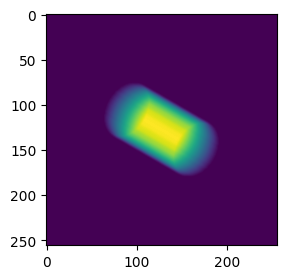

In [89]:
rotation = Rotation.from_euler('ZYX',[30,45,0],degrees=True).as_matrix()
proj_cylinder = project_rotated_cylinder(x,y,radius_circle=32,h=128, rotation=rotation)

plt.figure(figsize=(3,3))
plt.imshow(proj_cylinder)
proj_cylinder.sum()

In [83]:
h=128
radius_circle=32
n = x.shape[0]
Rxz, Ryz, Rzz = rotation[:, -1]
line_test = Rxz * y - Ryz * x  # intercept zero since cylinder centered
line_width_factor = 2
line_clipped = line_width_factor - np.clip(np.abs(line_test), a_min=0, a_max=line_width_factor)
n_border_x = int(np.round(n / 2 - h / 2 * np.abs(Rxz)))
n_border_y = int(np.round(n / 2 - h / 2 * np.abs(Ryz)))

# fails if n_border 0 or n//2
line_clipped[:n_border_y, :] = line_clipped[-n_border_y:, :] = line_clipped[:, :n_border_x] = line_clipped[:,
                                                                                              -n_border_x:] = 0
line = line_clipped
line_f = transforms.primal_to_fourier_2D(line)

ellipse = projected_rotated_circle(x, y, radius_circle, rotation)
ellipse_f = transforms.primal_to_fourier_2D(ellipse)
convolve = transforms.fourier_to_primal_2D(ellipse_f * line_f)
proj_cylinder = convolve.real.numpy()

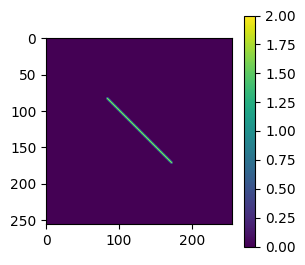

In [84]:
plt.figure(figsize=(3,3))
ax = plt.imshow(line)
plt.colorbar(ax)

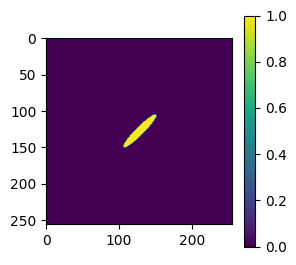

In [85]:
plt.figure(figsize=(3,3))
ax = plt.imshow(ellipse)
plt.colorbar(ax)

In [388]:


# 90 deg

# same direction, h ratio
rotation = Rotation.from_euler('XYZ',[45,45,0],degrees=True).as_matrix()
h_short = n//4
h_long = n//2
proj_cylinder_short = project_rotated_cylinder(x,y,radius_circle=32,h=h_short, rotation=rotation)
proj_cylinder_long = project_rotated_cylinder(x,y,radius_circle=32,h=h_long, rotation=rotation)
assert np.isclose(proj_cylinder_long.sum() / proj_cylinder_short.sum(), h_long/h_short, atol=1e-1)

small = 1e-3
overlap = np.logical_and(proj_cylinder_short > small, proj_cylinder_short > small)
assert np.allclose(overlap, proj_cylinder_short > small)

# same direction radius_circle ratio
rotation = Rotation.from_euler('XYZ',[45,45,0],degrees=True).as_matrix()
rad_fat = n//8
rad_thin = rad_fat//2
h=n//2
proj_cylinder_thin = project_rotated_cylinder(x,y,radius_circle=rad_thin,h=h, rotation=rotation)
proj_cylinder_fat = project_rotated_cylinder(x,y,radius_circle=rad_fat,h=h, rotation=rotation)
assert np.isclose(proj_cylinder_fat.sum() / proj_cylinder_thin.sum(), (rad_fat/rad_thin)**2, atol=1e-1)

small = 1e-3
overlap = np.logical_and(proj_cylinder_thin > small, proj_cylinder_fat > small)
assert np.allclose(overlap, proj_cylinder_thin > small)

# identity, circle of area h*pi*r^2
rotation_z_random = Rotation.from_euler('XYZ',[0,0,45],degrees=True).as_matrix()
proj_cylinder_z_random = project_rotated_cylinder(x,y,radius_circle=32,h=1, rotation=rotation_z_random)
proj_cylinder_id = project_rotated_cylinder(x,y,radius_circle=32,h=1, rotation=np.eye(3))
assert np.allclose(proj_cylinder_z_random,proj_cylinder_id)


# rectangle
for p90, m90, axis in [[[0,90,0],[0,-90,0],1],
                 [[90,0,0],[-90,0,0],0],
                 ]:
    rotation = Rotation.from_euler('XYZ',p90,degrees=True).as_matrix()
    h=128
    radius_circle=32
    proj_cylinder_side_p90 = project_rotated_cylinder(x,y,radius_circle=radius_circle,h=h, rotation=rotation)
    rotation = Rotation.from_euler('XYZ',m90,degrees=True).as_matrix()
    proj_cylinder_side_m90 = project_rotated_cylinder(x,y,radius_circle=radius_circle,h=h, rotation=rotation)
    assert np.allclose(proj_cylinder_side_p90,proj_cylinder_side_m90)
    assert np.isclose(proj_cylinder_side_p90.sum(axis).max(),h)
    diameter = 2*radius_circle
    area_rectangle = h*diameter
    assert np.isclose((proj_cylinder_side_p90 > small).sum(),area_rectangle ,atol=h)
    
for p, m, convention in [
    [[0,90,45],[0,90,-45], 'XZY'],
    [[0,90,45],[0,90,-45], 'YZX'],
                 ]:
    rotation_p = Rotation.from_euler(convention,p,degrees=True).as_matrix()
    rotation_m = Rotation.from_euler(convention,m,degrees=True).as_matrix()

    h=128
    radius_circle=32
    proj_cylinder_p = project_rotated_cylinder(x,y,radius_circle=radius_circle,h=h, rotation=rotation_p)
    proj_cylinder_m = project_rotated_cylinder(x,y,radius_circle=radius_circle,h=h, rotation=rotation_m)
    assert np.allclose(proj_cylinder_p,proj_cylinder_m)

else
else
else
else
about z-axis
about z-axis
90 deg, line along x-axis
90 deg, line along x-axis
90 deg, line along y-axis
90 deg, line along y-axis
90 deg, line along y-axis with z-tilt
90 deg, line along y-axis with z-tilt
90 deg, line along x-axis with z-tilt
90 deg, line along x-axis with z-tilt


In [1]:
from tests.test_geometric_micelle import test_project_rotated_cylinder
test_project_rotated_cylinder()


else
else
else
else
about z-axis
about z-axis
90 deg, line along x-axis
90 deg, line along x-axis
90 deg, line along y-axis
90 deg, line along y-axis
90 deg, line along y-axis with z-tilt
90 deg, line along y-axis with z-tilt
90 deg, line along x-axis with z-tilt
90 deg, line along x-axis with z-tilt


# `project_rotated_cylinder`: fix individual cases
* failing for rotations in `linearsimulator_tutorial.ipynb`

In [ ]:
# from simSPI.geometric_micelle import project_rotated_cylinder

# step_x = step_y = 1
# box_size = 128
# y_mesh, x_mesh = torch.meshgrid(torch.arange(-box_size//2, box_size//2, step=step_x),
#                                  torch.arange(-box_size//2, box_size//2, step=step_y))
# radius_circle=24
# h_outer=32
# from scipy.spatial.transform import Rotation
# # rotation = rot_params['rotmat'][1]#
# r3 = Rotation.from_matrix(rot_params['rotmat'][1].numpy()).as_euler('XYZ',degrees=True)
# assert np.allclose(Rotation.from_euler('XYZ',r3.tolist(),degrees=True).as_matrix(), rot_params['rotmat'][1].numpy(),atol=1e-3)
# rotation = torch.from_numpy(Rotation.from_euler('XYZ',r3.tolist(),degrees=True).as_matrix())
# proj_cylinder_outer = project_rotated_cylinder(x_mesh,
#                                                  y_mesh,
#                                                  radius_circle=radius_circle,
#                                                  h=h_outer,
#                                                  rotation=rotation)
# plt.imshow(proj_cylinder_outer)

else


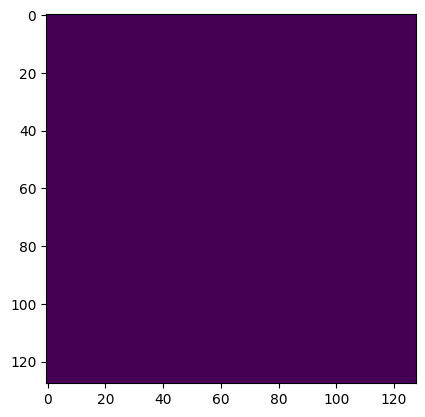

In [107]:
n=128
arr_1d = torch.arange(-n//2,n//2,1).float()
y, x = torch.meshgrid(arr_1d,arr_1d)
# rotation = Rotation.from_euler('XYZ', [ 90,  0, -90],degrees=True).as_matrix()
# rotation = tensor([[-0.0735,  0.9972, -0.0147],
#         [-0.1030, -0.0222, -0.9944],
#         [-0.9920, -0.0716,  0.1044]])
rotation = torch.from_numpy(Rotation.from_euler('XYZ', [ 84.00753554,  -0.84101199, -94.21614645],degrees=True).as_matrix())

h=32
radius_circle=24
proj_cylinder = project_rotated_cylinder(x,y,radius_circle=radius_circle,h=h, rotation=rotation)
plt.imshow(proj_cylinder)

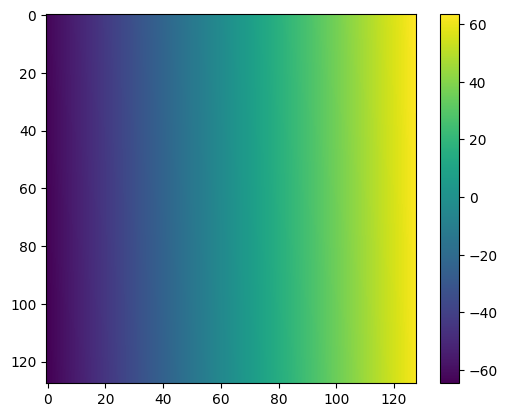

In [108]:
Rxz, Ryz, Rzz = rotation[:, -1].numpy()
line_test = Rxz * y - Ryz * x
ax = plt.imshow(line_test)
plt.colorbar(ax)

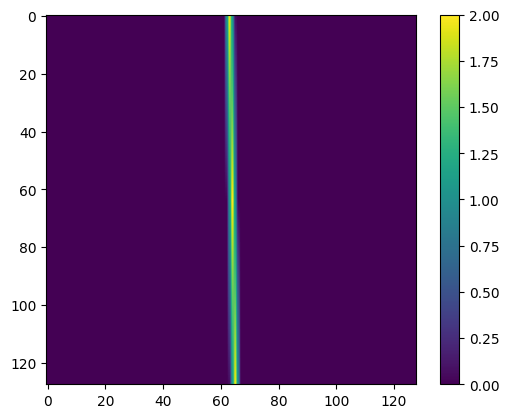

In [119]:
line_width_factor = 2 # sqrt 2 ?
line_clipped = line_width_factor - torch.clamp(line_test.abs(), min=0, max=line_width_factor)
ax = plt.imshow(line_clipped)
plt.colorbar(ax)

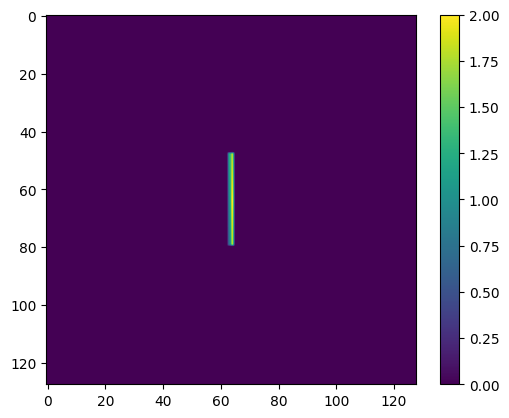

In [124]:
n_border_x = round(n / 2 - h / 2 * abs(Rxz))
n_border_y = round(n / 2 - h / 2 * abs(Ryz))
def min_max_border(n_border,n):
    '''prevents line from dissappearing when n_border is 0 or n//2'''
    min_space = 1
    n_border = min(n//2-min_space,n_border)
    n_border = max(min_space,n_border)
    return n_border
n_border_x = min_max_border(n_border_x,n)
n_border_y = min_max_border(n_border_y,n)

line_clipped[:n_border_y, :] = line_clipped[-n_border_y:, :] = line_clipped[:, :n_border_x] = line_clipped[:,
                                                                                              -n_border_x:] = 0
line = line_clipped
ax = plt.imshow(line)
plt.colorbar(ax)

In [133]:
Rxz_mesh, Ryz_mesh = np.meshgrid(np.arange(-1,1,0.01),np.arange(-1,1,0.01))
n_border_x = np.round(n / 2 - h / 2 * np.abs(Rxz_mesh))
n_border_y = np.round(n / 2 - h / 2 * np.abs(Ryz_mesh))

for i in range(n):
    for j in range(n):
        assert 0 < min_max_border(n_border_x[i,j],n)
        assert min_max_border(n_border_x[i,j],n) < n//2
        assert 0 < min_max_border(n_border_y[i,j],n)
        assert min_max_border(n_border_y[i,j],n) < n//2

In [126]:
n_border_x

63